In [1]:
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
import colorsys
from sklearn.cluster import spectral_clustering, KMeans
from scipy import sparse 

In [145]:
border = Image.open('border.jpg')
# Resize image to allow for faster computational time 
border = border.resize((25,25))
borderColor = np.asarray(border)

# Function to reduce a nxmx3 image to nxm  
def mapTo2D(img,x):
    img2D = []
    for row in img: 
        newRow = []
        for entry in row: 
            (h,s,v) = colorsys.rgb_to_hsv(entry[0]/255, entry[1]/255, entry[2]/255)
            gray = (0.3*entry[0] + 0.59*entry[1] + 0.11*entry[2])/255
            (r,g,b) = (entry[0]/255, entry[1]/255, entry[2]/255)
            vals = {"h": h, "s": s, "v": v, "gray": gray, "r":r, "g":g, "b": b}
            newRow.append(vals[x])
        img2D.append(np.asarray(newRow))
    return np.asarray(img2D)

In [146]:
borderV = mapTo2D(borderColor, "v")
borderMask = np.full(borderV.shape, True) # make the mask the entire shape 
# convert to image to graph 
graph = image.img_to_graph(borderV, mask = borderMask)
# modify the graph such that more similar = smaller weight 
graph.data = np.exp(-graph.data/graph.data.std())

borderLabels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
borderLabel_im = np.full(borderMask.shape, -1.0)
borderLabel_im[borderMask] = borderLabels

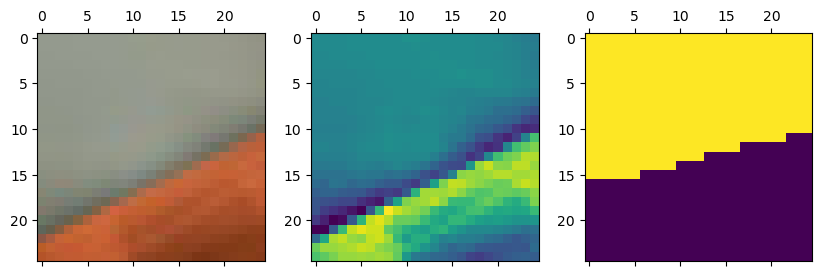

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(borderColor)
axs[1].matshow(borderV)
axs[2].matshow(borderLabel_im)
plt.show()

In [148]:
# Import images and get black and white and color representation as arrays
coins = Image.open('coins.png')
#coins = Image.open('sugar.png')
coins = coins.resize((50,50))
coinsColor = np.asarray(coins)
coinsBW = mapTo2D(coinsColor, "gray")

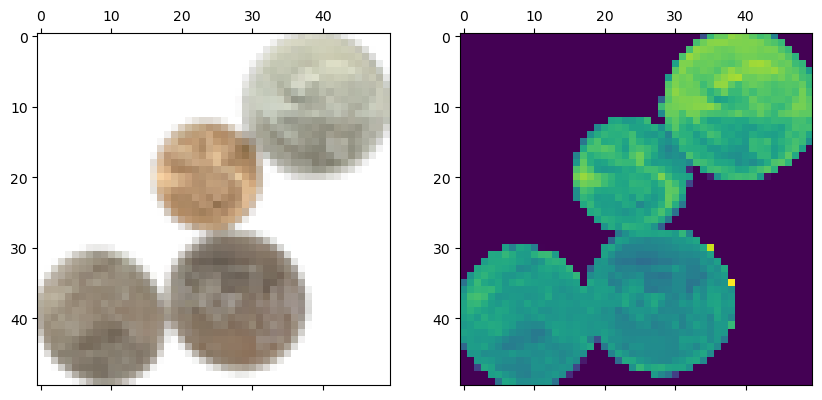

In [149]:
# Display images below
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(coinsColor)
axs[1].matshow(coinsBW)
plt.show()

In [150]:
imgMask = []
# If not transparent, then mark pixels as park of mask we want to consider
for row in coinsColor: 
    newRow = []
    for entry in row: 
        newRow.append(entry[3] > 50)
    imgMask.append(np.asarray(newRow))
imgMask = np.asarray(imgMask)

In [151]:
# create the graph from the image 
graph = image.img_to_graph(coinsBW, mask = imgMask)
graph.data = np.exp(-graph.data/graph.data.std())

In [152]:
# separate into clusters
# if segmenting coins.png, set n_cluster to 4, if doing the the segmenting sugar.png, set n_cluster to 2
labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(imgMask.shape, -1.0)
label_im[imgMask] = labels

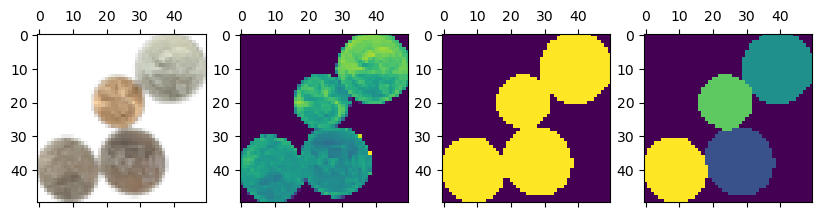

In [153]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs[0].matshow(coinsColor)
axs[1].matshow(coinsBW)
axs[2].matshow(imgMask)
axs[3].matshow(label_im)
plt.show()

1. Original image 
2. Image after being converted black and white 
3. Image of mask, the image we are trying to find cuts in 
4. Image with the four cuts. 

Preliminary results generated from only using black and white images to find the min cut. However, this only relies on the difference in value, black and white so it doesn't account for other difference in color. Since the graph's edges are determined by this difference in pixels, instead of looking at difference in value (black and white), look at other differences

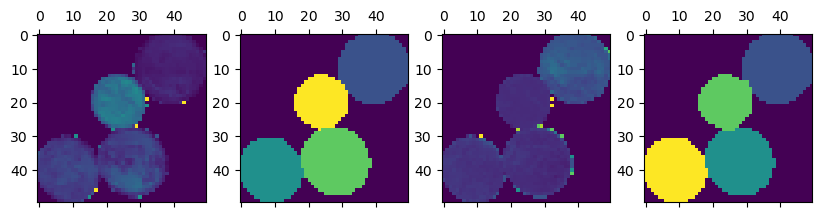

In [154]:
coinsS = mapTo2D(coinsColor, "s") #get only saturation
coinsH = mapTo2D(coinsColor, "h") #get only hue

coinsSGraph = image.img_to_graph(coinsS, mask = imgMask)
coinsHGraph = image.img_to_graph(coinsH, mask = imgMask)
coinsSGraph.data = np.exp(-coinsSGraph.data/graph.data.std())
coinsHGraph.data = np.exp(-coinsHGraph.data/graph.data.std())

labelsS = spectral_clustering(coinsSGraph, n_clusters=4, eigen_solver="arpack")
label_imS = np.full(imgMask.shape, -1.0)
label_imS[imgMask] = labelsS

labelsH = spectral_clustering(coinsHGraph, n_clusters=4, eigen_solver="arpack")
label_imH = np.full(imgMask.shape, -1.0)
label_imH[imgMask] = labelsH

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs[0].matshow(coinsS)
axs[1].matshow(label_imS)
axs[2].matshow(coinsH)
axs[3].matshow(label_imH)
plt.show()

On the left, saturation plot with the segmentation based on satuation value
On the right, hue plot with the segmentation based on hue value. 

Instead of relying on the spectral clustering function and image_to_graph function, try modifying it

In [155]:
# Load image 
simpleImg = Image.open('simple2.png')
simple = mapTo2D(np.asarray(simpleImg), "gray")


W = np.zeros(shape=(9,9))
# determine the weight matrix, the adjacency matrix 
# only use pixels that are <= 1 in euclidean distance away from the current pixel (it's neighbors)
changes =[]
for x in range(len(simple)):
    for y in range(len(simple[0])):
        def computeWeight(i, j, a, b): 
            if a >= 0 and a < len(simple) and b >= 0 and b < len(simple[0]):
                # difference = gradient
                difference = np.abs(simple[i][j] - simple[a][b])
                
                W[i*len(simple[0])+j][a*len(simple[0])+b] = difference
                W[a*len(simple[0])+b][i*len(simple[0])+j] = difference
        computeWeight(x, y, x+1, y)
        computeWeight(x, y, x, y+1)
        computeWeight(x, y, x-1, y)
        computeWeight(x, y, x, y-1)

D = np.diag(W.sum(axis=1))

#Computing L only based on pixel affinity graph
L = D-W     

eigvals, eigvecs = np.linalg.eig(L)

# sort these based on the eigenvalues
eigvecs = eigvecs[:,np.argsort(eigvals)]
eigvals = eigvals[np.argsort(eigvals)]

# kmeans on 2nd vectors with nonzero eigenvalues
kmeansSimple = KMeans(n_clusters=2)
kmeansSimple.fit(eigvecs[:,1:2])
simpleLables = np.split(kmeansSimple.labels_, 3)

In [156]:
# create the baseline using the spectral clustering function in sklearn
simpleMask = np.full(simple.shape, True) # make the mask the entire shape 
# convert to image to graph 
simpleGraph = image.img_to_graph(simple, mask = simpleMask)
# modify the graph such that more similar = smaller weight 
simpleGraph.data = np.exp(-simpleGraph.data/simpleGraph.data.std())

simpleLabelsBaseline = spectral_clustering(simpleGraph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(simpleMask.shape, -1.0)
label_im[simpleMask] = simpleLabelsBaseline

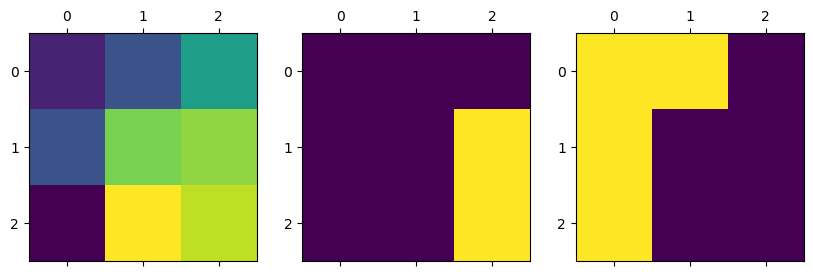

In [157]:
#visualize the data 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(simple)
axs[1].matshow(simpleLables)
axs[2].matshow(label_im)
plt.show()

1. original image 
2. labels assigned using the method implemented above 
3. labels assigned using the spectral clustering function in sklearn 

Did not to a very good job since the cut includes two pixels that should not be there. 

In [158]:
W = np.zeros(shape=(625,625))
# determine the weight matrix, the adjacency matrix 
# only use pixels that are <= 1 in euclidean distance away from the current pixel (it's neighbors)
changes =[]
for x in range(len(borderV)):
    for y in range(len(borderV[0])):
        def computeWeight(i, j, a, b): 
            if a >= 0 and a < len(borderV) and b >= 0 and b < len(borderV[0]):
                # difference = gradient
                difference = np.abs(borderV[i][j] - borderV[a][b])
                
                W[i*len(borderV[0])+j][a*len(borderV[0])+b] = difference
                W[a*len(borderV[0])+b][i*len(borderV[0])+j] = difference
        computeWeight(x, y, x+1, y)
        computeWeight(x, y, x, y+1)
        computeWeight(x, y, x-1, y)
        computeWeight(x, y, x, y-1)

D = np.diag(W.sum(axis=1))

#Computing L only based on pixel affinity graph
L = D-W     

eigvals, eigvecs = np.linalg.eig(L)

eigvecs = np.real(eigvecs )
# sort these based on the eigenvalues
eigvecs = eigvecs[:,np.argsort(eigvals)]
eigvals = eigvals[np.argsort(eigvals)]

# compute k means on 2nd smallest eigevector
kmeansSimple = KMeans(n_clusters=2)
kmeansSimple.fit(eigvecs[:,1:2])
borderLables = np.split(kmeansSimple.labels_, 25)

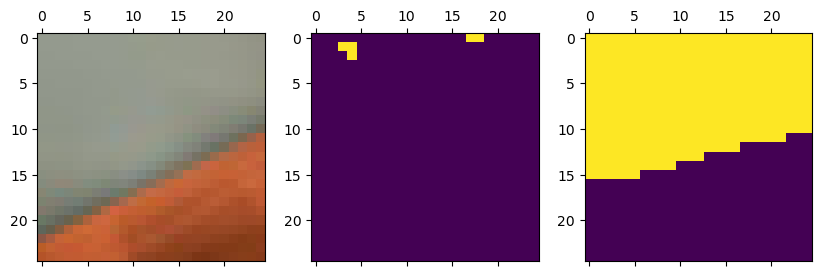

In [159]:
#visualize the data 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(borderColor)
axs[1].matshow(borderLables)
axs[2].matshow(borderLabel_im)
plt.show()

Did a very poor job at segmenting the image. 
1. original image converted to black and white 
2. image segmented using pixel affinity 
3. image segmented using sklearn spectral clsutering

may have something to do with inaccuracy of using numpy.eig to calculate eigenvectors. Sklearn uses argpack, which is specially designed for sparse matrices. Since we did not use argpack here, the 2nd smallest eigenvectors may not be means of partitioning the pixels into two groups. 

Since the img_to_graph function only works with nxm matrices, unable to account for distance between colors. Ie two images may have similar gray value but are different in other ways. By looking at the euclidean norm of the distance between colors, may provide better segmentation. 

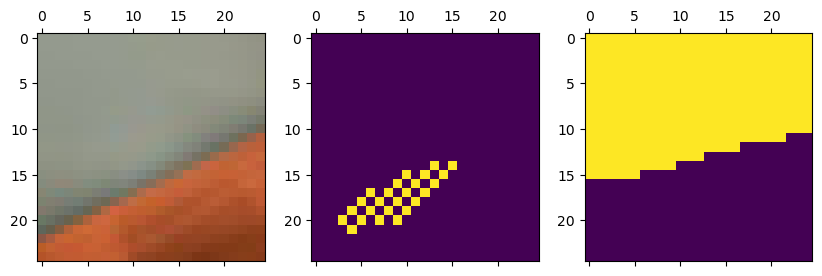

In [160]:
# compute adjavency matrix for R, G, and B
graph_R = image.img_to_graph(mapTo2D(borderColor, "r"), mask = borderMask).toarray()
graph_G = image.img_to_graph(mapTo2D(borderColor, "g"), mask = borderMask).toarray()
graph_B = image.img_to_graph(mapTo2D(borderColor, "b"), mask = borderMask).toarray()

# compute the euclidean norm of the distance between each color 
graph_Color = np.sqrt(np.square(graph_R) + np.square(graph_G) + np.square(graph_B))
graph_Color_std = graph_Color.std()
graph_Color = np.exp((-1*graph_Color)/graph_Color_std)

# perform spectral clustering 
borderLabels = spectral_clustering(graph_Color, n_clusters=2, eigen_solver="arpack")
label_im = np.full(borderMask.shape, -1.0)
label_im[borderMask] = borderLabels

#visualize the data 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axs[0].matshow(borderColor)
axs[1].matshow(label_im)
axs[2].matshow(borderLabel_im)
plt.show()

The plot on the left shows the original image. The plot the right shows the original border image using spectral clustering with just the gray values. The plot in the middle shows the graph using all values. It does seem to detect some part of that lower region, but has a checkered pattern, indicating some neighboring pixels are ignored. Thus, this still did a poor job.